In [3]:
import os
import subprocess
import random
import warnings
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import unitary_group
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm.notebook import tqdm
import itertools

import torch
from qucumber.nn_states import DensityMatrix
from qucumber.nn_states import ComplexWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.training_statistics as ts
import qucumber.utils.cplx as cplx
import qucumber.utils.data as data
from qucumber.observables import ObservableBase, to_pm1
from qucumber.observables.pauli import flip_spin
import qucumber

from qulacs.gate import Pauli

%load_ext autoreload
%autoreload 2
import target_circuit
import statistics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
with open('./params_setting.yaml', 'r') as yml:
    params = yaml.safe_load(yml)
    
# quantum circuit parameter
circuit_name = params["circuit_info"]["circuit_name"]
n_qubit = params["circuit_info"]["n_qubit"]
state_class = params["circuit_info"]["state_class"]
error_model = params["circuit_info"]["error_model"]
error_rate = params["circuit_info"]["error_rate"]
each_n_shot = params["circuit_info"]["each_n_shot"]

# RBM architecture parameter
num_visible = params["architecture_info"]["n_visible_unit"]
num_hidden = params["architecture_info"]["n_hidden_unit"] 
num_aux = params["architecture_info"]["n_aux_unit"]

# train parameter
lr = params["train_info"]["lr"]
pbs = params["train_info"]["positive_batch_size"]
nbs = params["train_info"]["negative_batch_size"]
n_gibbs_step = params["train_info"]["n_gibbs_step"]
period = 1
epoch = params["train_info"]["n_epoch"]
lr_drop_epoch = params["train_info"]["lr_drop_epoch"]
lr_drop_factor = params["train_info"]["lr_drop_factor"]
use_gpu = params["train_info"]["use_gpu"]
seed = params["train_info"]["seed"]

# sampling parameter
n_sampling = params["sampling_info"]["n_sample"]
n_copy = params["sampling_info"]["n_copy"]

# data path info
environment = "local"
if environment == "local":
    train_data_path = f"./{circuit_name}/data/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    target_state_path = f"./{circuit_name}/target_state/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/"
    model_path = f"./{circuit_name}/model/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    train_log_path = f"./{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
if environment == "colab":
    from google.colab import drive
    drive.mount("/content/drive/")
    drive_path = "/content/drive/MyDrive/NQS4VD/GHZ"
    train_data_path = drive_path + f"/{circuit_name}/data/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    target_state_path = drive_path + f"/{circuit_name}/target_state/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/"
    model_path = drive_path + f"/{circuit_name}/model/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    train_log_path = drive_path + f"/{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"


def seed_settings(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    qucumber.set_random_seed(seed, cpu=True, gpu=False)

seed_settings(seed=seed)

## depolarizing error

In [14]:
nn_state_dep = DensityMatrix.autoload(f"./{circuit_name}/model/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/epoch500_model.pt")
obs_mat = Pauli([0, 1, 2, 3], [3, 3, 3, 3]).get_matrix()
n_copy_list = np.arange(1, 31)
bias_dep_list = []
ideal_state = target_circuit.GHZ(n_qubit, state_class, "ideal", error_rate)

for n_copy in tqdm(n_copy_list):
    bias_dep = statistics.bias(nn_state_dep, ideal_state, n_copy, obs_mat)
    bias_dep_list.append(bias_dep)

  0%|          | 0/30 [00:00<?, ?it/s]

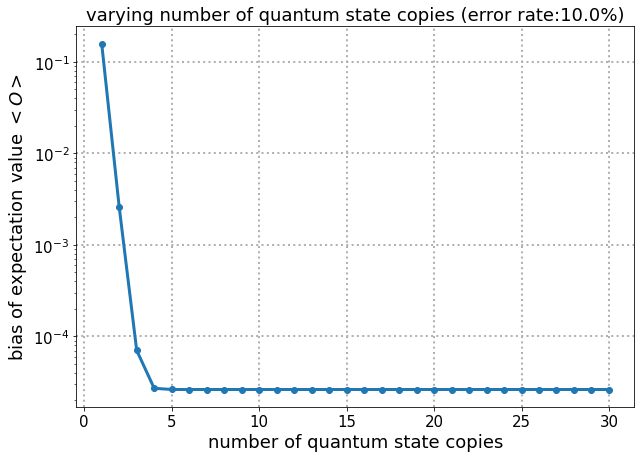

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(n_copy_list, bias_dep_list, marker="o", linewidth=3)
plt.title(f'varying number of quantum state copies (error rate:{error_rate*100}%)', fontsize=18)
plt.xlabel('number of quantum state copies', fontsize=18)
plt.ylabel('bias of expectation value $<O>$', fontsize=18)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)

In [27]:
n_samples = 1000
var_dep_list = []
pauli_dict = {0:"Z", 1:"Z", 2:"Z", 3:"Z"}
for n_copy in tqdm(n_copy_list):
    var_dep = statistics.variance(nn_state_dep, pauli_dict, n_samples, n_copy)
    var_dep_list.append(bias_dep)

  0%|          | 0/30 [00:00<?, ?it/s]

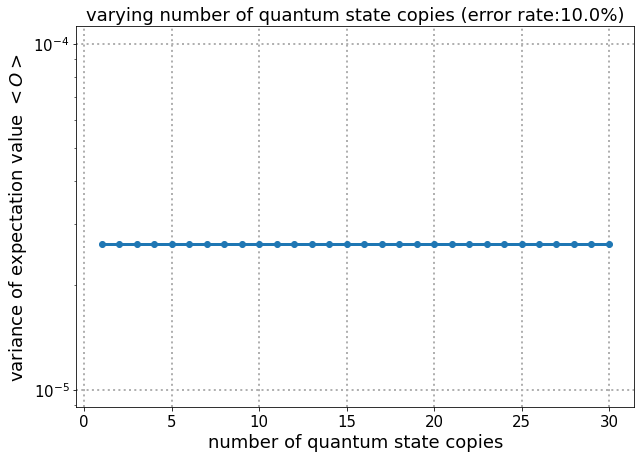

In [28]:
plt.figure(figsize=(10, 7))
plt.plot(n_copy_list, var_dep_list, marker="o", linewidth=3)
plt.title(f'varying number of quantum state copies (error rate:{error_rate*100}%)', fontsize=18)
plt.xlabel('number of quantum state copies', fontsize=18)
plt.ylabel('variance of expectation value $<O>$', fontsize=18)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)

In [ ]:
nn_state_dep = DensityMatrix.autoload(f"./model_dm/depolarizing/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/epoch500_model.pt")
nn_state_uni = DensityMatrix.autoload(f"./model_dm/unitary/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/epoch500_model.pt")
nn_state_dep_uni = DensityMatrix.autoload(f"./model_dm/depolarizing&unitary/error_rate_{100*error_rate}%/num_of_data_{each_n_shot}/epoch500_model.pt")
pauli_dict = {0:"Z", 1:"Z"}

bias_dep_list = []
bias_uni_list = []
bias_dep_uni_list = []
n_copy_list = [1, 2, 3, 4, 5]

for n_copy in tqdm(n_copy_list):
    bias_dep = bias(nn_state_dep, pauli_dict, n_sample, n_copy)
    bias_uni = bias(nn_state_uni, pauli_dict, n_sample, n_copy)
    bias_dep_uni = bias(nn_state_uni, pauli_dict, n_sample, n_copy)
    
    bias_dep_list.append(bias_dep)
    bias_uni_list.append(bias_uni)
    bias_dep_uni_list.append(bias_dep_uni)

bias_data = [bias_dep_list, bias_uni_list, bias_dep_uni_list]

  0%|          | 0/5 [00:00<?, ?it/s]

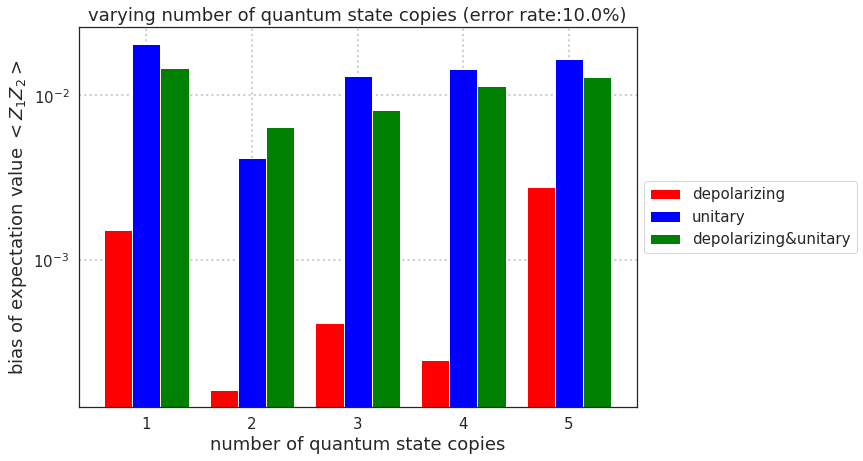

In [8]:
x = np.arange(1, 6)
labels = ["depolarizing", "unitary", "depolarizing&unitary"]
tick_label = np.arange(1, 6).astype("str")
margin = 0.2
totoal_width = 1 - margin
color_list = ["red", "blue", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(bias_data, labels, color_list)):
    pos = x - totoal_width * (1- (2*i+1)/len(bias_data))/2
    plt.bar(pos, h, width = totoal_width/len(bias_data), label=label, tick_label=tick_label, align="center", color=c)

plt.title(f'varying number of quantum state copies (error rate:{error_rate*100}%)', fontsize=18)
plt.xlabel('number of quantum state copies', fontsize=18)
plt.ylabel('bias of expectation value $<Z_1 Z_2>$', fontsize=18)
plt.yscale('log')
plt.xticks(x, tick_label)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)

In [9]:
var_dep_list = []
var_uni_list = []
var_dep_uni_list = []
n_copy_list = [1, 2, 3, 4, 5]
n_est = 100

for n_copy in tqdm(n_copy_list):
    var_dep = variance(nn_state_dep, pauli_dict, n_sample, n_copy, n_est)
    var_uni = variance(nn_state_uni, pauli_dict, n_sample, n_copy, n_est)
    var_dep_uni = variance(nn_state_uni, pauli_dict, n_sample, n_copy, n_est)
    
    var_dep_list.append(var_dep)
    var_uni_list.append(var_uni)
    var_dep_uni_list.append(var_dep_uni)

var_data = [var_dep_list, var_uni_list, var_dep_uni_list]

  0%|          | 0/5 [00:00<?, ?it/s]

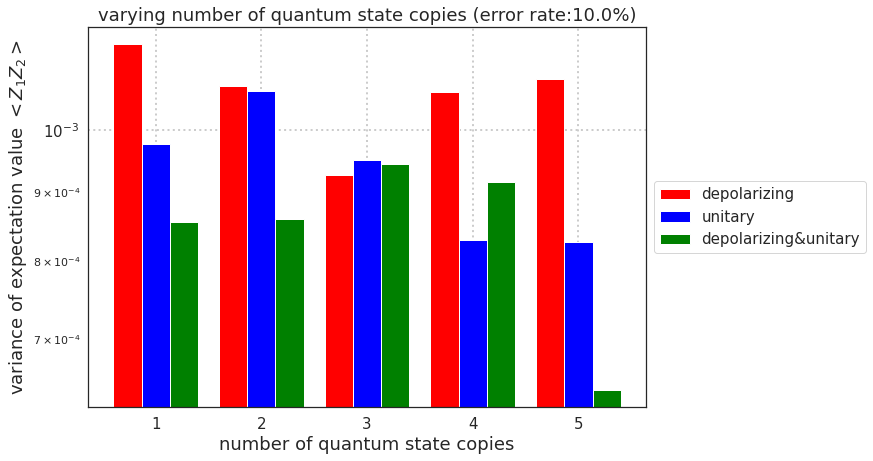

In [13]:
x = np.arange(1, 6)
labels = ["depolarizing", "unitary", "depolarizing&unitary"]
tick_label = np.arange(1, 6).astype("str")
margin = 0.2
totoal_width = 1 - margin
color_list = ["red", "blue", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(var_data, labels, color_list)):
    pos = x - totoal_width * (1- (2*i+1)/len(var_data))/2
    plt.bar(pos, h, width = totoal_width/len(var_data), label=label, tick_label=tick_label, align="center", color=c)

plt.title(f'varying number of quantum state copies (error rate:{error_rate*100}%)', fontsize=18)
plt.xlabel('number of quantum state copies', fontsize=18)
plt.ylabel('variance of expectation value $<Z_1 Z_2>$', fontsize=18)
plt.xticks(x, tick_label)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)

In [11]:
mse_data = [np.array(bias_dep_list)+np.array(var_dep_list),
            np.array(bias_uni_list)+np.array(var_uni_list),
            np.array(bias_dep_uni_list)+np.array(var_dep_uni_list)]

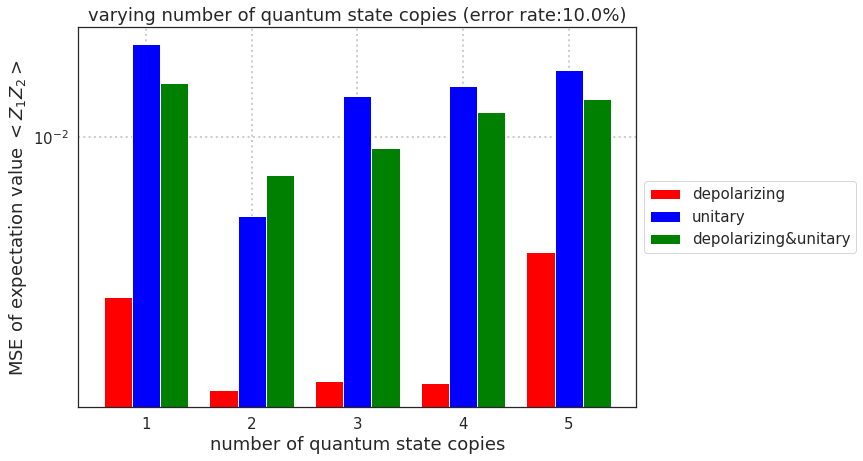

In [14]:
x = np.arange(1, 6)
labels = ["depolarizing", "unitary", "depolarizing&unitary"]
tick_label = np.arange(1, 6).astype("str")
margin = 0.2
totoal_width = 1 - margin
color_list = ["red", "blue", "green"]
plt.figure(figsize=(10, 7))

for i, (h, label, c) in enumerate(zip(mse_data, labels, color_list)):
    pos = x - totoal_width * (1- (2*i+1)/len(mse_data))/2
    plt.bar(pos, h, width = totoal_width/len(mse_data), label=label, tick_label=tick_label, align="center", color=c)

plt.title(f'varying number of quantum state copies (error rate:{error_rate*100}%)', fontsize=18)
plt.xlabel('number of quantum state copies', fontsize=18)
plt.ylabel('MSE of expectation value $<Z_1 Z_2>$', fontsize=18)
plt.xticks(x, tick_label)
plt.yscale('log')
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=15)